In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40149 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 103.08 GB


In [3]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_cont_kpp.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_nostress_cont_kpp'

## Introduction

This notebook aims to find a suitable parametrisation for resolved velocity shear in terms of friction velocity, coriolis frequency and a specific depth z.

In [4]:
dVsq = cc.querying.getvar(expt = expt, session = session, variable = 'dVsq', frequency = '1 daily')
ustar = cc.querying.getvar(expt = expt, session = session, variable = 'ustar', frequency = '1 daily')
hblt = cc.querying.getvar(expt = expt, session = session, variable = 'hblt', frequency = '1 daily', ncfile = 'ocean-2d-hblt-1-daily-snap-ym_1900_01.nc')
temp = cc.querying.getvar(expt = expt, session = session, variable = 'surface_temp', frequency = '1 monthly')

#### Convert both ustar and hblt to u

In [7]:
import xgcm

data = xr.merge((hblt,ustar,dVsq))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)
data.coords['st_ocean'].attrs.update(axis='Z')

g = xgcm.Grid(data, periodic=['X'])
u = g.interp(hblt,'X')
hblt = g.interp(u,'Y',boundary="extend")

g = xgcm.Grid(data, periodic=['X'])
u = g.interp(ustar,'X')
ustar = g.interp(u,'Y',boundary="extend")

### Plotting the interpolated and measured dVsq for a specific latitude and depth

The interpolated dVsq is given by:

$$ dVsq = \frac{z (u_{\star} + 80 u^2_{\star})}{60} e^{-\frac{10^{-4}} {u_{\star}^{-0.5}} z} $$

In [8]:
import pandas as pd

#### Example 1

In [9]:
%%time

x_val = -30
z_val = 10

# At a specific longitude, take all latitudes' hblt value
hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-09-01','1900-09-02')).mean('time')

# Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
# resolved velocity shear only in the KPP mixing layer
mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

# Use this mask and obtain the ustar values for the specific longitude and all latitudes
ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-09-01','1900-09-02')).mean('time'))*mask).values

# Outputted value of dVsq, multiplied by the mask
dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-09-01','1900-09-02')).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

# Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
itp_dVsq = (ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
data = {'dVsq': dVsq_trunc.values,
         'Itp': itp_dVsq
        }

dVsq_stocean_df = pd.DataFrame(data = data)
print(dVsq_stocean_df.corr().values[0][1])

0.9129628140232036
CPU times: user 4.93 s, sys: 259 ms, total: 5.19 s
Wall time: 12.5 s


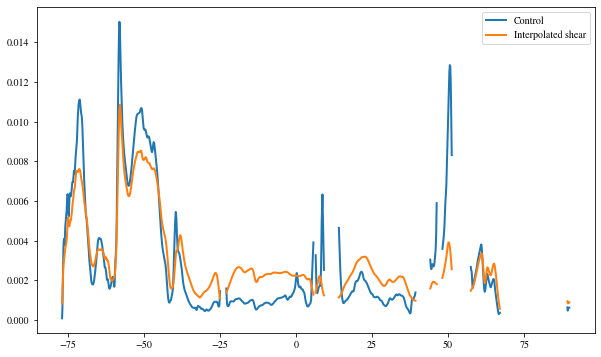

In [10]:
plt.figure(figsize = (10,6))
plt.plot(dVsq.yu_ocean, dVsq_trunc.values, label = 'Control')
plt.plot(dVsq.yu_ocean, itp_dVsq, label = 'Interpolated shear')
plt.legend()

#### Example 2

In [11]:
x_val = -170
z_val = 5

# At a specific longitude, take all latitudes' hblt value
hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-06-01','1900-06-02')).mean('time')

# Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
# resolved velocity shear only in the KPP mixing layer
mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

# Use this mask and obtain the ustar values for the specific longitude and all latitudes
ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-06-01','1900-06-02')).mean('time'))*mask).values

# Outputted value of dVsq, multiplied by the mask
dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice('1900-06-01','1900-06-02')).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

# Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
itp_dVsq = (1*ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
data = {'dVsq': dVsq_trunc.values,
         'Itp': itp_dVsq
        }

dVsq_stocean_df = pd.DataFrame(data = data)
print(dVsq_stocean_df.corr().values[0][1])

0.45816914738134307


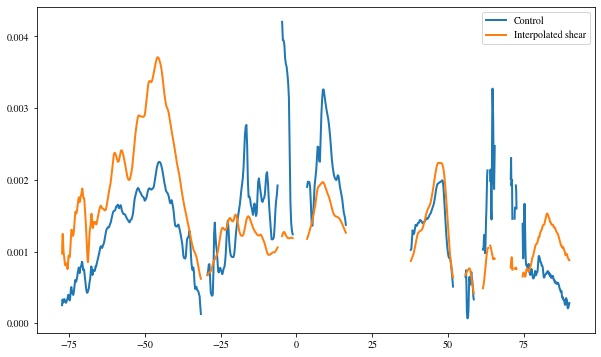

In [12]:
plt.figure(figsize = (10,6))
plt.plot(dVsq.yu_ocean, dVsq_trunc.values, label = 'Control')
plt.plot(dVsq.yu_ocean, itp_dVsq, label = 'Interpolated shear')
plt.legend()

### Dvsq for an entire year for a specific longitude and depth

#### Example 1

In [42]:
x_val = -180
z_val = 10

for i in range(0,360):
    t_start = hblt.time[int(i)]
    t_end = hblt.time[int(i+1)]
    # At a specific longitude, take all latitudes' hblt value
    hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time')

    # Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
    # resolved velocity shear only in the KPP mixing layer
    mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

    # Use this mask and obtain the ustar values for the specific longitude and all latitudes
    ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time'))*mask).values

    # Outputted value of dVsq, multiplied by the mask
    dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

    # Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
    #itp_dVsq = (0.05*ustar_val + 150*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    itp_dVsq = (1*ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    data = {'dVsq': dVsq_trunc.values,
             'Itp': itp_dVsq
            }

    dVsq_stocean_df = pd.DataFrame(data = data)
    corr_array[int(i)] = (dVsq_stocean_df.corr().values)[0][1]

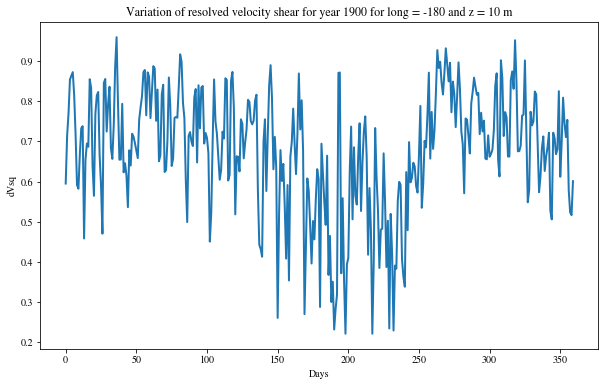

In [51]:
plt.figure(figsize = (10,6))
plt.plot(np.linspace(0,359,360),corr_array[0:360])
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of resolved velocity shear for year 1900 for long = ' + str(x_val) + ' and z = ' + str(z_val) + ' m')
plt.savefig('Ex_param')

In [25]:
corr_array[corr_array == 0] = np.nan
np.nanmean(corr_array)

0.6323164564331333

#### Example 2

In [ ]:
x_val = -40
z_val = 10

for i in range(0,360):
    t_start = hblt.time[int(i)]
    t_end = hblt.time[int(i+1)]
    # At a specific longitude, take all latitudes' hblt value
    hblt_trunc = hblt.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time')

    # Create a mask - this mask should be 1 if hblt at that location is deeper than z_val, otherwise the data is no use to us, since we want to properly evaluate 
    # resolved velocity shear only in the KPP mixing layer
    mask = hblt_trunc.where(hblt_trunc > z_val)/hblt_trunc

    # Use this mask and obtain the ustar values for the specific longitude and all latitudes
    ustar_val = ((ustar.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time'))*mask).values

    # Outputted value of dVsq, multiplied by the mask
    dVsq_trunc = (dVsq.sel(xu_ocean = x_val, method = 'nearest').sel(time = slice(t_start,t_end)).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask

    # Interpolated dVsq considering only those locations where the hblt is deeper than z_val.
    #itp_dVsq = (0.05*ustar_val + 150*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    itp_dVsq = (1*ustar_val + 80*ustar_val**2) * (np.exp(-1e-4*z_val/ustar_val**0.5)) * (z_val/60)
    data = {'dVsq': dVsq_trunc.values,
             'Itp': itp_dVsq
            }

    dVsq_stocean_df = pd.DataFrame(data = data)
    corr_array[int(i)] = (dVsq_stocean_df.corr().values)[0][1]

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(np.linspace(0,359,360),corr_array[0:360])
plt.xlabel('Days')
plt.ylabel('dVsq')
plt.title('Variation of resolved velocity shear for year 1900 for long = ' + str(x_val) + ' and z = ' + str(z_val) + ' m')
plt.savefig('Ex_param')

In [ ]:
corr_array[corr_array == 0] = np.nan
np.nanmean(corr_array)

### Dvsq variation for a specific latitude-longitude and depth.

In [22]:
z_array = dVsq.st_ocean.values
t_lim = 360
z_lim = 8
corr_array = np.zeros((t_lim,z_lim))

for i in range(0,t_lim):
    t_start = hblt.time[int(i)]
    t_end = hblt.time[int(i+1)]
    hblt_trunc = hblt.sel(time = slice(t_start,t_end)).mean('time')
    ustar_trunc = ustar.sel(time = slice(t_start,t_end)).mean('time')
    for j,depth in enumerate(z_array[2:2+z_lim]):
        mask = hblt_trunc.where(hblt_trunc > depth)/hblt_trunc
        ustar_trunc = ustar_trunc*mask
        dVsq_trunc = (dVsq.sel(time = slice(t_start,t_end)).mean('time').sel(st_ocean = z_val, method = 'nearest'))*mask
        itp_dVsq = (1*ustar_trunc + 80*ustar_trunc**2) * (np.exp(-1e-4*depth/ustar_trunc**0.5)) * (depth/60)
        
        data =  {'dVsq': dVsq_trunc.values.flatten(),
                 'Itp': itp_dVsq.values.flatten()
                }
        dVsq_stocean_df = pd.DataFrame(data = data)
        corr_array[int(i),j] = (dVsq_stocean_df.corr().values)[0][1]
    if(i%30 == 0):
        print(i)

0


KeyboardInterrupt: 

In [24]:
corr_array[0:20,:]

array([[0.90005927, 0.92056973, 0.93753179, 0.95003715, 0.95861254,
        0.96486284, 0.97003959, 0.97255326],
       [0.88731673, 0.91028362, 0.92805111, 0.94065592, 0.94902193,
        0.95612292, 0.96413483, 0.96781158],
       [0.88006768, 0.90696066, 0.92996267, 0.94746329, 0.95827148,
        0.96439724, 0.96981132, 0.97411575],
       [0.87210334, 0.89362221, 0.9176116 , 0.93613211, 0.94648997,
        0.950154  , 0.95266744, 0.95555265],
       [0.86926715, 0.89220163, 0.91487878, 0.93088351, 0.94087852,
        0.94874879, 0.95353412, 0.95697336],
       [0.85782105, 0.88397654, 0.91095819, 0.92814981, 0.93993834,
        0.94622239, 0.95065446, 0.95810405],
       [0.85916973, 0.88502681, 0.90718629, 0.92506107, 0.93675816,
        0.94411824, 0.95015024, 0.95698572],
       [0.86799688, 0.89152736, 0.91056794, 0.92453431, 0.93633864,
        0.94303171, 0.94846915, 0.95397602],
       [0.85997881, 0.89076291, 0.9125438 , 0.92874006, 0.93892379,
        0.94486101, 0.948115